In [1]:
%%capture
!apt install python3-dev graphviz libgraphviz-dev pkg-config
!pip install networkx pygraphviz matplotlib ges

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import ges

from networkx.drawing.nx_agraph import graphviz_layout
from typing import List

In [3]:
# Get machine epsilon.
e = np.finfo(np.float64).eps

# Learning Bayesian Networks from Data with Greedy Equivalent Search (GES)

## Introduction

GES (short for Greedy Equivalence Search) is a score-based algorithm for causal inference which tries to find the causal network behind the observational data.

The search is guided by a proper scoring criterion, which evaluates the goodness-of-fit between a given graph and the data, and it has to be optimized. Bayesian Information Criterion (BIC) is proved to be among those suitable metrics, and is chosen as our metric to be maximized.

The computation of BIC is divided in multiple steps (functions):

- N(X,Z,D): extracts the absolute frequencies of observing in the dataframe D the 'r' various states of X through all the 'q' possible configurations of the variables in the set Z and saves them in a matrix (numpy array) 'q x r'

- ℓℓ(X,Z,D): using the elements of N(X,Z,D), computes the local log-likelihood of variable X in relation to the set of variables Z according to the dataframe D

- LL(G,D): computes the log-likelihood of the graph G according to the dataset D by summing the values of ℓℓ(X,parents(X),D) for all variables X in G

- BIC(G,D): computes BIC of graph G according to dataset D, exploiting LL(G,D) for the first term of the formula.

The peculiarity of GES is its capability of traversing through the space of CPDAGs, the equivalence classes of DAGs sharing the same sets of conditional independencies (d-separated sets of variables): the output of GES, therefore, is the CPDAG representative of the class where the causal network of interest belongs, which can be subsequently inferred exploiting domain expertise.

GES starts from an empty network (unique representative of its equivalence class) and applies two algorithms in sequence:

- FES (Forward Equivalence Search): during each step, among a selection of graphs, created by adding an arc to the stored CPDAG and adjusting edge direction accordingly, the one with maximum BIC is chosen to replace the previous CPDAG. This graph obtained is generally a PDAG, in which case it's converted to the corrispondent CPDAG. The search stops when the BIC reaches local maximum (that is, any edge addition results in graphs with lower BIC than the current CPDAG)

- BES (Backward Equivalence Search): the output of FES is given to BES which, in a mirror fashion, iteratively deletes arcs and adjust edge directions to eventually obtain a CPDAG that reaches local maximum BIC (which is GES's final output).

Graph modeling, operations and property extractions are carried thanks to the 'networkx' package.


## Implementation

In [4]:
# additional imports
import itertools
from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return set(chain.from_iterable(set(combinations(s, r) for r in range(len(s)+1))))

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Read Data and Graph

In [6]:
# Read data from file.
D = pd.read_csv("/content/drive/MyDrive/final_project_data.csv", dtype = "category")
# Build the true graph.
G = nx.DiGraph([
    ("A", "T"),
    ("S", "L"),
    ("S", "B"),
    ("B", "D"),
    ("E", "D"),
    ("T", "E"),
    ("L", "E"),
    ("E", "X")
])

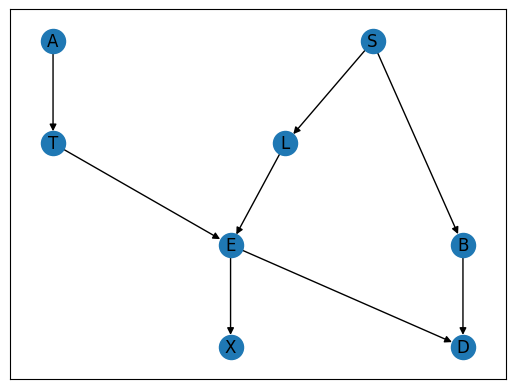

In [7]:
nx.draw_networkx(G, pos = graphviz_layout(G, prog = "dot"), with_labels = True)

### Computing the Absolute Frequencies

In [8]:
# Compute the absolute frequencies N(X, Pa(X) | D).
def N(X: str, Z: List[str], D: pd.DataFrame) -> np.ndarray:

    if len(Z)!=0:

      N=D.groupby(by=Z).value_counts(X).to_numpy(dtype=np.int64)
      return np.reshape(N, newshape= (np.prod(D[Z].nunique()),D.X.nunique()))

    else:
      return np.array([D[X].value_counts().to_numpy()])

In [9]:
# Compute N(A | D).
np.testing.assert_equal(
    N("A", [], D),
    np.array([[4958,   42]])
)

In [10]:
# Compute N(A, [L] | D).
np.testing.assert_equal(
    N("A", ["L"], D),
    np.array([
        [4632,   38],
        [ 326,    4]
    ])
)

In [11]:
# Compute N(A, [L, T] | D).
np.testing.assert_equal(
    N("A", ["L", "T"], D),
    np.array([
        [4594,   36],
        [  38,    2],
        [ 322,    4],
        [   4,    0]
    ])
)

### Computing the Log-Likelihood



In [12]:
from math import log10, log
# Compute the log-likelihood ll(X, Pa(X) | D).
def ll(X: str, Z: List[str], D: pd.DataFrame) -> float:

    freqs=N(X,Z,D)
    local_ll=0

    for j in range(0,freqs.shape[0]):
      row_sum=np.sum(freqs[j])
      for k in range(0,freqs.shape[1]):
        if(freqs[j][k]>0):
          local_ll+= freqs[j][k] * log( freqs[j][k] / row_sum )

    return local_ll


In [13]:
# Compute ll(A | D).
np.testing.assert_approx_equal(
    ll("A", [], D),
    -242.5631
)

In [14]:
# Compute ll(A, [L] | D).
np.testing.assert_approx_equal(
    ll("A", ["L"], D),
    -242.3023
)

In [15]:
# Compute ll(A, [L, T] | D).
np.testing.assert_approx_equal(
    ll("A", ["L", "T"], D),
    -240.2226
)

In [16]:
# Compute the Log-Likelihood LL(G | D).
def LL(G: nx.DiGraph, D: pd.DataFrame) -> float:

    Log_Likelihood=0

    for n in G.nodes:
      parents=[u for u in G.nodes if G.has_edge(u,n)]
      Log_Likelihood+=ll(n,parents,D)

    return Log_Likelihood

In [17]:
# Compute LL(G | D).
np.testing.assert_approx_equal(
    LL(G, D),
    -11033.0871
)

### Computing the BIC

In [18]:
# Compute the Bayesian Information Criterion BIC(G | D).
def BIC(G: nx.DiGraph, D: pd.DataFrame) -> float:

    bic=2*LL(G,D)
    regularizer=0

    for n in G.nodes:

      parents=[u for u in G.nodes if G.has_edge(u,n)]
      regularizer+=np.prod(N(n,parents,D).shape)

    bic -= log(D.shape[0]) * regularizer
    return bic

#check BIC value for graph G
print("BIC(G,D) =",BIC(G,D))

BIC(G,D) = -22372.7932224327


### Implementing GES

In [19]:
# FS implementation
def FS(G: nx.DiGraph, D: pd.DataFrame):

  xy_edge=None
  T_subset=set()
  #for easier access to matrix indexes
  node_list=dict(zip(G.nodes,range(len(G.nodes))))
  #to reapply the same labeling on our graphs
  mapping=dict(zip(range(len(G.nodes)),G.nodes))

  G_mat=nx.adjacency_matrix(G).todense()
  #compute starting BIC on a specific DAG in the equivalence class of G
  new_G=nx.from_numpy_array(ges.utils.pdag_to_dag(G_mat),create_using=nx.DiGraph)
  nx.relabel_nodes(new_G,mapping,copy=False)
  best=BIC(new_G,D)

  for x in G.nodes:
    for y in (G.nodes-{x}):
      # y must be not adjacent to x
      if (G_mat[node_list[x],node_list[y]]==0 and G_mat[node_list[y],node_list[x]]==0):
        # find neighbors of y not adjacent to x
        set_T={

            z for z in G.nodes-{x,y}

            if(
                (G_mat[node_list[z],node_list[x]]==0 and G_mat[node_list[x],node_list[z]]==0)
            and
                (G_mat[node_list[z],node_list[y]]==1 and G_mat[node_list[y],node_list[z]]==1)
              )
               }

        for T in powerset(set_T):

          #apply insertion
          G_mat[node_list[x],node_list[y]]=1
          for t in T:
              G_mat[node_list[y],node_list[t]]=0
          #check insertion validity
          try:
            ges.utils.pdag_to_dag(G_mat)
          except:
            G_mat=nx.adjacency_matrix(G).todense()
            continue
          else:
            #compute BIC of modified graph
            G_mat=ges.utils.pdag_to_dag(G_mat)
            new_G=nx.from_numpy_array(G_mat,create_using=nx.DiGraph)
            nx.relabel_nodes(new_G,mapping,copy=False)
            delta=BIC(new_G,D)
            #BIC comparison
            if (delta > best):
              best=delta
              xy_edge=(x,y)
              T_subset=T

            G_mat=nx.adjacency_matrix(G).todense()

  return (xy_edge,T_subset)


In [20]:
# BS implementation
def BS(G: nx.DiGraph, D: pd.DataFrame):

  xy_edge=None
  H_subset=set()

  #for easier access to matrix indexes
  node_list=dict(zip(G.nodes,range(len(G.nodes))))
  #to reapply the same labeling on our graphs
  mapping=dict(zip(range(len(G.nodes)),G.nodes))

  G_mat=nx.adjacency_matrix(G).todense()
  #compute starting BIC on a specific DAG in the equivalence class of G
  G_eq=nx.from_numpy_array(ges.utils.pdag_to_dag(G_mat),create_using=nx.DiGraph)
  nx.relabel_nodes(G_eq,mapping,copy=False)
  best=BIC(G_eq,D)

  for x in G.nodes:
    for y in (G.nodes-{x}):
      # y must be adjacent to x (x-y or x->y)
      if (G_mat[node_list[x],node_list[y]]==1):
        # find neighbors of y adjacent to x
        set_H={

            z for z in G.nodes-{x,y}

            if(
                (G_mat[node_list[z],node_list[x]]==1 or G_mat[node_list[x],node_list[z]]==1)
            and
                (G_mat[node_list[z],node_list[y]]==1 and G_mat[node_list[y],node_list[z]]==1)
              )
               }

        for H in powerset(set_H):
          #apply deletion
          G_mat[node_list[x],node_list[y]]=0
          G_mat[node_list[y],node_list[x]]=0
          for h in H:
              G_mat[node_list[h],node_list[y]]=0
              if(G_mat[node_list[h],node_list[x]]==1 and G_mat[node_list[x],node_list[h]]==1):
                G_mat[node_list[h],node_list[x]]=0
          #check deletion validity
          try:
            ges.utils.pdag_to_dag(G_mat)
          except:
            G_mat=nx.adjacency_matrix(G).todense()
            continue
          else:
            #compute BIC of modified graph
            G_mat=ges.utils.pdag_to_dag(G_mat)
            new_G=nx.from_numpy_array(G_mat,create_using=nx.DiGraph)
            nx.relabel_nodes(new_G,mapping,copy=False)
            delta=BIC(new_G,D)
            #BIC comparison
            if (delta > best):
              best=delta
              xy_edge=(x,y)
              H_subset=H

            G_mat=nx.adjacency_matrix(G).todense()

  return (xy_edge,H_subset)


In [21]:
# FES implementation
def FES(G: nx.DiGraph, D: pd.DataFrame) -> nx.DiGraph:

  #to reapply the same labeling on our graphs
  node_list=dict(zip(range(len(G.nodes)),G.nodes))

  (arc,T)=FS(G,D)
  G_matrix=nx.adjacency_matrix(G).todense()

  while arc!=None:
    #add arc x->y
    G_matrix[list(G.nodes).index(arc[0]),list(G.nodes).index(arc[1])]=1
    #change y-t to t->y
    for t in T:
      G_matrix[list(G.nodes).index(arc[1]),list(G.nodes).index(t)]=0
    #conversion to CPDAG
    G_matrix=ges.utils.pdag_to_cpdag(G_matrix)
    G=nx.from_numpy_array(G_matrix,create_using=nx.DiGraph)
    nx.relabel_nodes(G,node_list,copy=False)

    (arc,T)=FS(G,D)

  return G

In [22]:
# BES implementation
def BES(G: nx.DiGraph, D: pd.DataFrame) -> nx.DiGraph:

  #to reapply the same labeling on our graphs
  node_list=dict(zip(range(len(G.nodes)),G.nodes))

  (arc,H)=BS(G,D)
  G_matrix=nx.adjacency_matrix(G).todense()

  while arc!=None:
    #delete arc x-y
    G_matrix[list(G.nodes).index(arc[0]),list(G.nodes).index(arc[1])]=0
    G_matrix[list(G.nodes).index(arc[1]),list(G.nodes).index(arc[0])]=0
    #change y-h to y->h and any x-h to x->h
    for h in H:
      G_matrix[list(G.nodes).index(h),list(G.nodes).index(arc[1])]=0
      if(G_matrix[list(G.nodes).index(h),list(G.nodes).index(arc[0])]==1 and
         G_matrix[list(G.nodes).index(arc[0]),list(G.nodes).index(h)]==1):
        G_matrix[list(G.nodes).index(h),list(G.nodes).index(arc[0])]=0
    #conversion to CPDAG
    G_matrix=ges.utils.pdag_to_cpdag(G_matrix)
    G=nx.from_numpy_array(G_matrix,create_using=nx.DiGraph)
    nx.relabel_nodes(G,node_list,copy=False)

    (arc,H)=BS(G,D)

  return G

In [23]:
# GES implementation
def GES(D: pd.DataFrame) -> nx.DiGraph:

  G=nx.DiGraph()
  G.add_nodes_from(D.columns.values)
  G=FES(G,D)
  G=BES(G,D)

  return G
#nx.draw_networkx(BES(FES(G,D),D), pos = graphviz_layout(G, prog = "dot"),with_labels = True)

In [24]:
E = GES(D)

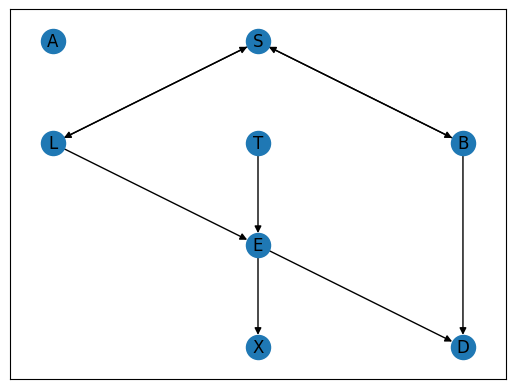

In [25]:
nx.draw_networkx(E, pos = graphviz_layout(E, prog = "dot"), with_labels = True)

### Testing GES

In [26]:
#summary
print("Common Edges:", E.edges & G.edges)
print("Missing Edges:", G.edges - E.edges)
print("Extra Edges:", E.edges - G.edges)
print("Reversed Edges:", E.edges & G.reverse().edges)

Common Edges: {('S', 'B'), ('T', 'E'), ('E', 'D'), ('E', 'X'), ('L', 'E'), ('S', 'L'), ('B', 'D')}
Missing Edges: {('A', 'T')}
Extra Edges: {('B', 'S'), ('L', 'S')}
Reversed Edges: {('B', 'S'), ('L', 'S')}


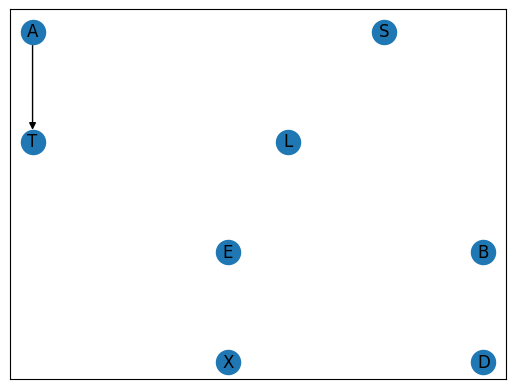

In [27]:
#visual comparison with graph difference
nx.draw_networkx(nx.difference(G,E), pos = graphviz_layout(G, prog = "dot"), with_labels = True)